# Customer Churn Prediction

Customer Churn is the measure of the the amount of people who stop subscribing or buying a product over time. In situations where consumers are subscribing to a service, it is important to measure how likely those people are to stop subscribing because it may allow the marketing team to intervene in an attempt to stop him/her from churning. This can be accomplished by sending the user a discount code, reaching out to the user for a personalized review of the product in order to find pain points, etc. In this demo, when churn is true, it will hold the value of 1. When a customer does not churn, it will hold a value of 0.

### Imports

In [15]:
# Import our favorite data science packages
import scipy
import importlib
import os
import pandas as pd
import numpy as np
import seaborn as sns

# We also will need a list of plotting libraries 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


# Import the libraries needed to import data from UCI into pandas
import re
import requests
import io

# Import sklearn libraries
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, f1_score, recall_score, auc, precision_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import cross_val_score

# Import the support libraries
from collections import OrderedDict

## Data Collection

In [2]:
url_name = "https://raw.githubusercontent.com/3Blades/notebook-templates/master/python/marketing/churndata.csv"
request=requests.get(url_name).content
churn_data = pd.read_csv(io.StringIO(request.decode('utf-8')))
print(churn_data.head())

  State  Account Length  Area Code     Phone Int'l Plan VMail Plan  \
0    KS             128        415  382-4657         no        yes   
1    OH             107        415  371-7191         no        yes   
2    NJ             137        415  358-1921         no         no   
3    OH              84        408  375-9999        yes         no   
4    OK              75        415  330-6626        yes         no   

   VMail Message  Day Mins  Day Calls  Day Charge   ...    Eve Calls  \
0             25     265.1        110       45.07   ...           99   
1             26     161.6        123       27.47   ...          103   
2              0     243.4        114       41.38   ...          110   
3              0     299.4         71       50.90   ...           88   
4              0     166.7        113       28.34   ...          122   

   Eve Charge  Night Mins  Night Calls  Night Charge  Intl Mins  Intl Calls  \
0       16.78       244.7           91         11.01       10.0    

## Data Cleaning
In this phase, we're going to clean the data to make it look a bit prettier. Some of the columns probably aren't going to be helpful in the long term and some of the columns need to be converted into numerical formats so that they can be inputted into sklearn and other machine learning model types.

In [3]:
# Let's now 
# First, we need to clean each column, including the column names
churn_exp = churn_data.copy()
churn_exp.rename(columns={'Churn?': 'Churn'}, inplace=True)

# Now, you have to clean the columns
churn_exp.loc[:, 'Churn'] = churn_exp.loc[:, 'Churn'].map(lambda x: re.sub('[.]',
    '', x))

# Now we need to convert the columns to something more usable. You also would need to know what columns need to be changed, 
# which can be a chore if you have hundreds of rows of data.

churn_exp.loc[:, 'VMail Plan'].replace('yes', 1, inplace=True)
churn_exp.loc[:, 'VMail Plan'].replace('no', 0, inplace=True)
churn_exp.loc[:, 'Int\'l Plan'].replace('yes', 1, inplace=True)
churn_exp.loc[:, 'Int\'l Plan'].replace('no', 0, inplace=True)

# Now, we have to change the labels that we have to predict:

churn_exp.loc[:, 'Churn'].replace('False', 0, inplace=True)
churn_exp.loc[:, 'Churn'].replace('True', 1, inplace=True)

# We now have to find and standardize the columns of the data for the algorithms like Logistic Regression.

from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler() # Assume .25, .75 quantiles
# This will be a hard part.... 
# Also, it gives you a way to focus on what's important instead of being bombarded with a bunch of information at once. 
churn_exp[['Account Length', 'VMail Message', 'Day Mins', 'Day Calls', 
         'Day Charge', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Eve Mins' ,
         'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 
         'Intl Charge', 'CustServ Calls']] =  StandardScaler().fit_transform(churn_exp[['Account Length', 'VMail Message',
                                                                                        'Day Mins', 'Day Calls', 
         'Day Charge', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Eve Mins',
         'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 
         'Intl Charge', 'CustServ Calls']])

# Now, because each phone number is unique, we can simply drop it.
churn_exp.drop('Phone', axis=1, inplace=True)
print(churn_exp.head())

  State  Account Length  Area Code  Int'l Plan  VMail Plan  VMail Message  \
0    KS        0.676489        415           0           1       1.234883   
1    OH        0.149065        415           0           1       1.307948   
2    NJ        0.902529        415           0           0      -0.591760   
3    OH       -0.428590        408           1           0      -0.591760   
4    OK       -0.654629        415           1           0      -0.591760   

   Day Mins  Day Calls  Day Charge  Eve Mins  Eve Calls  Eve Charge  \
0  1.566767   0.476643    1.567036 -0.070610  -0.055940   -0.070427   
1 -0.333738   1.124503   -0.334013 -0.108080   0.144867   -0.107549   
2  1.168304   0.675985    1.168464 -1.573383   0.496279   -1.573900   
3  2.196596  -1.466936    2.196759 -2.742865  -0.608159   -2.743268   
4 -0.240090   0.626149   -0.240041 -1.038932   1.098699   -1.037939   

   Night Mins  Night Calls  Night Charge  Intl Mins  Intl Calls  Intl Charge  \
0    0.866743    -0.465494    

## Feature Engineering
Normally, a data scientist would conduct exploratory data analysis in order to find out more information about the customer base. In this example, we're going to go straight into the prediction phase and attempt to make the customer base machine learning ready (the exploratory phase is covered in the Churn Plotly Notebook).  One of the most important parts of the data scientist's workflow is that we have to create the right features for us to input into the machine learning algorithm. The idea is that we have to ensure that the features are in the correct format while also maximizing information and minimizing the number of features to avoid curse of dimensionality problems with the data. Right now, we're attmepting to maxim

In [4]:
# First we have to do something about the states. Do let's convert them to dummy variables.
import sys
print(churn_exp)
state_columns = churn_exp['State'].unique()
for state in state_columns:
    churn_exp.loc[:, state] = (churn_exp.loc[:, 'State'] == state).astype('int')
churn_exp.drop('State', axis=1, inplace=True)

# You would also have to do something with area codes as well
area_code_columns = churn_exp['Area Code'].unique()
for area_code in area_code_columns:
    churn_exp.loc[:, 'Area Code: ' + str(area_code)] = (churn_exp.loc[:, 'Area Code'] == area_code).astype('int')
churn_exp.drop('Area Code', axis=1, inplace=True)

# Now, we need to rename the column name.
churn_exp.rename(columns={'Churn?' : "Churn"}, inplace=True)
print(churn_exp.head())

     State  Account Length  Area Code  Int'l Plan  VMail Plan  VMail Message  \
0       KS        0.676489        415           0           1       1.234883   
1       OH        0.149065        415           0           1       1.307948   
2       NJ        0.902529        415           0           0      -0.591760   
3       OH       -0.428590        408           1           0      -0.591760   
4       OK       -0.654629        415           1           0      -0.591760   
5       AL        0.425335        510           1           0      -0.591760   
6       MA        0.500681        510           0           1       1.161817   
7       MO        1.153683        415           1           0      -0.591760   
8       LA        0.400220        408           0           0      -0.591760   
9       WV        1.002990        415           1           1       2.111671   
10      IN       -0.905784        415           0           0      -0.591760   
11      RI       -0.679745        415   

   Account Length  Int'l Plan  VMail Plan  VMail Message  Day Mins  Day Calls  \
0        0.676489           0           1       1.234883  1.566767   0.476643   
1        0.149065           0           1       1.307948 -0.333738   1.124503   
2        0.902529           0           0      -0.591760  1.168304   0.675985   
3       -0.428590           1           0      -0.591760  2.196596  -1.466936   
4       -0.654629           1           0      -0.591760 -0.240090   0.626149   

   Day Charge  Eve Mins  Eve Calls  Eve Charge       ...        KY  ME  MS  \
0    1.567036 -0.070610  -0.055940   -0.070427       ...         0   0   0   
1   -0.334013 -0.108080   0.144867   -0.107549       ...         0   0   0   
2    1.168464 -1.573383   0.496279   -1.573900       ...         0   0   0   
3    2.196759 -2.742865  -0.608159   -2.743268       ...         0   0   0   
4   -0.240041 -1.038932   1.098699   -1.037939       ...         0   0   0   

   TN  PA  CT  ND  Area Code: 415  Area Code

## Model Development

,Algorithm Name,Cross Validation Error,Accuracy,F1 Scores,Roc Auc Score,Precision,Recall
0,Decision Trees,0.827032,0.914414,0.719212,0.827830,0.737374,0.701923
1,Logistic Regression,0.800488,0.849850,0.264706,0.574083,0.562500,0.173077
2,Random Forests,0.891966,0.914414,0.641509,0.741634,0.927273,0.490385
3,K Nearest Neighbors,0.774736,0.876877,0.388060,0.621441,0.866667,0.250000


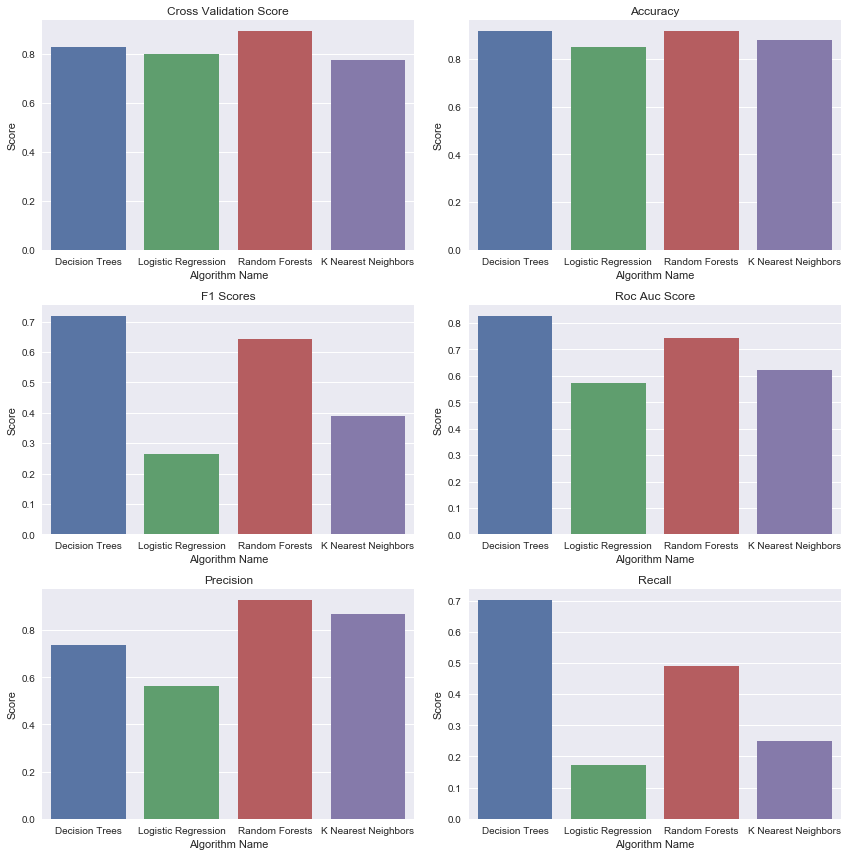

In [37]:
from IPython.display import display, HTML

# Split the data between training and testing data.
churn_exp = shuffle(churn_exp)
cutoff_x = int(churn_exp.shape[0]*.80) # We assume an 80% split
start_y = cutoff_x + 1
X_train = churn_exp.drop('Churn', axis=1, inplace=False).iloc[0:cutoff_x, :]
Y_train = churn_exp['Churn'][0:cutoff_x]
X_test = churn_exp.drop('Churn', axis=1, inplace=False).iloc[start_y:, :]
Y_test = churn_exp['Churn'][start_y:]

# Score Matrices
score_matrix = pd.DataFrame(columns=['Algorithm Name', 'Cross Validation Error', 
                                     'Accuracy', 'F1 Scores', 'Roc Auc Score', 'Precision', 'Recall'])

# Decision Trees
from sklearn import tree
DT = tree.DecisionTreeClassifier()
# The score difference between the highest and lowest model is X_score
# Based on 3 different criteria, the average difference between the average 
DT.fit(X_train, Y_train)
Y_pred = DT.predict(X_test)
score_matrix.loc[0] = ['Decision Trees', np.mean(cross_val_score(DT, X_train, Y_train, scoring='roc_auc', cv=10)), 
                       accuracy_score(Y_test, Y_pred), f1_score(Y_test, Y_pred), roc_auc_score(Y_test, Y_pred), 
                       precision_score(Y_test, Y_pred),recall_score(Y_test, Y_pred)]

objects = ("Accuracy", "F1 Score", "Roc Auc Curve", "Precision", "Recall")
performance = [accuracy_score(Y_test, Y_pred), f1_score(Y_test, Y_pred), roc_auc_score(Y_test, Y_pred),
    precision_score(Y_test, Y_pred), recall_score(Y_test, Y_pred)]

"""
# For those that prefer Matplotlib instead
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.title("Decision Trees")
plt.show()
"""


# Logsitic Regression
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(penalty='l2', C=1e5)
logistic.fit(X_train, Y_train)
Y_pred = logistic.predict(X_test)
score_matrix.loc[1] = ['Logistic Regression', np.mean(cross_val_score(logistic, X_train, Y_train, scoring='roc_auc', cv=10)), 
                       accuracy_score(Y_test, Y_pred), f1_score(Y_test, Y_pred), roc_auc_score(Y_test, Y_pred), 
                       precision_score(Y_test, Y_pred),recall_score(Y_test, Y_pred)]

objects = ("Accuracy", "F1 Score", "Roc Auc Curve", "Precision", "Recall")
y_pos = np.arange(len(objects))
performance = [accuracy_score(Y_test, Y_pred), f1_score(Y_test, Y_pred), roc_auc_score(Y_test, Y_pred),
    precision_score(Y_test, Y_pred), recall_score(Y_test, Y_pred)]

"""
# For those that prefer Matplotlib instead
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.title("Logistic Regression")
plt.show()
"""

# Random Forests
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_test)
score_matrix.loc[2] = ['Random Forests', np.mean(cross_val_score(rf, X_train, Y_train, scoring='roc_auc', cv=10)), 
                       accuracy_score(Y_test, Y_pred), f1_score(Y_test, Y_pred), roc_auc_score(Y_test, Y_pred), 
                       precision_score(Y_test, Y_pred),recall_score(Y_test, Y_pred)]

objects = ("Accuracy", "F1 Score", "Roc Auc Curve", "Precision", "Recall")
y_pos = np.arange(len(objects))
performance = [accuracy_score(Y_test, Y_pred), f1_score(Y_test, Y_pred), roc_auc_score(Y_test, Y_pred),
    precision_score(Y_test, Y_pred), recall_score(Y_test, Y_pred)]

"""
# For those that prefer Matplotlib instead
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.title('Random Forests')
plt.show()
"""


# K Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn.fit(X_train, Y_train)
# Find the optimal parameters (Yuo would have to gridsearch or random search them)
Y_pred = knn.predict(X_test)
objects = ("Accuracy", "F1 Score", "Roc Auc Curve", "Precision", "Recall")
y_pos = np.arange(len(objects))
score_matrix.loc[3] = ['K Nearest Neighbors', np.mean(cross_val_score(knn, X_train, Y_train, scoring='roc_auc', cv=10)), 
                       accuracy_score(Y_test, Y_pred), f1_score(Y_test, Y_pred), roc_auc_score(Y_test, Y_pred), 
                       precision_score(Y_test, Y_pred),recall_score(Y_test, Y_pred)]
"""
# For those that prefer Matplotlib instead
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.title("K Nearest Neighbors")
plt.show()
"""

display(score_matrix)

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

ax = sns.barplot(x='Algorithm Name', y="Cross Validation Error", data=score_matrix, ax=axs[0][0])
ax.set(ylabel='Score', title='Cross Validation Score')

ax2 = sns.barplot(x='Algorithm Name', y="Accuracy", data=score_matrix, ax=axs[0][1])
ax2.set(ylabel='Score', title='Accuracy')

ax3 = sns.barplot(x='Algorithm Name', y="F1 Scores", data=score_matrix, ax=axs[1][0])
ax3.set(ylabel='Score', title='F1 Scores')

ax4 = sns.barplot(x='Algorithm Name', y="Roc Auc Score", data=score_matrix, ax=axs[1][1])
ax4.set(ylabel='Score', title='Roc Auc Score')

ax5 = sns.barplot(x='Algorithm Name', y="Precision", data=score_matrix, ax=axs[2][0])
ax5.set(ylabel='Score', title='Precision')

ax6 = sns.barplot(x='Algorithm Name', y="Recall", data=score_matrix, ax=axs[2][1])
ax6.set(ylabel='Score', title='Recall')

fig.tight_layout()